# Contour Regularization
This part creates regularized building outlines from the pixel results outputted by the network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Contour finding with marching squares

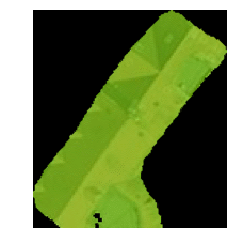

In [51]:
import os
p = os.path.join(os.getcwd(), "test", "data", "bigL.bmp")
image = plt.imread(p)

fig, ax = plt.subplots()
ax.imshow(image)
ax.axis('off')  # clear x- and y-axes
plt.show()

No handles with labels found to put in legend.


max threshold:  62


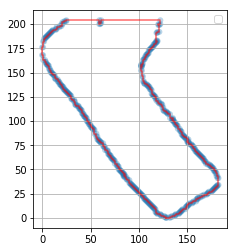

In [52]:
from core.utils import MarchingSquares

m = MarchingSquares.from_file(p)
points = m.find_contour(approximization_tolerance=0.01)
main_orientation = m.main_orientation(angle_in_degrees=True)

x = np.asarray(list(map(lambda p: p[0], points)))
y = np.asarray(list(map(lambda p: p[1], points)))

fig, ax = plt.subplots()
ax.set(aspect='equal')
ax.scatter(x, y, alpha=0.3, edgecolors='none')
plt.plot(x, y, color="red", alpha=0.6)

ax.legend()
ax.grid(True)

plt.show()

## Segmentation of the contour

From 533 points we got 44 line segments.


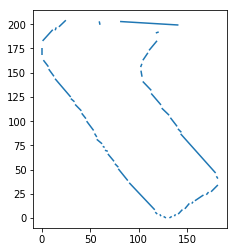

In [53]:
from core.utils import make_lines
from matplotlib import collections  as mc

lines = make_lines(points.copy())
print("From {} points we got {} line segments.".format(len(points), len(lines)))

lc = mc.LineCollection(lines)
fig, ax = plt.subplots()
ax.set(aspect='equal')
ax.add_collection(lc)
ax.autoscale()

## The line segments are then group by parallelity and perpendicularity...

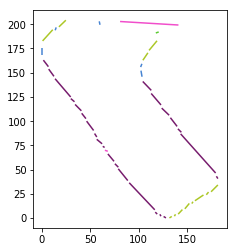

In [54]:
from core.utils import group_by_orientation

fig, ax = plt.subplots()
ax.set(aspect='equal')
grouped_lines = group_by_orientation(lines.copy())
for angle in grouped_lines:
    group = grouped_lines[angle]
    for ori in group:
        line_group = group[ori]
        lc = mc.LineCollection(line_group, colors=np.random.rand(3,))
        ax.add_collection(lc)
ax.autoscale()

## ...and after that, nearest neighbour clusters are created within each group

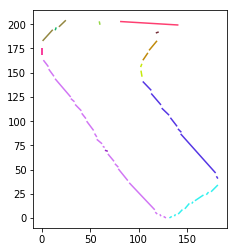

In [55]:
from core.utils import group_neighbours
import copy

new_groups = copy.deepcopy(grouped_lines)
group_neighbours(new_groups)

fig, ax = plt.subplots()
ax.set(aspect='equal')
for angle in new_groups:
    group = new_groups[angle]
    for ori in group:
        line_group = group[ori]
        for subgroup in line_group:
            lc = mc.LineCollection(subgroup, colors=np.random.rand(3,))
            ax.add_collection(lc)
ax.autoscale()

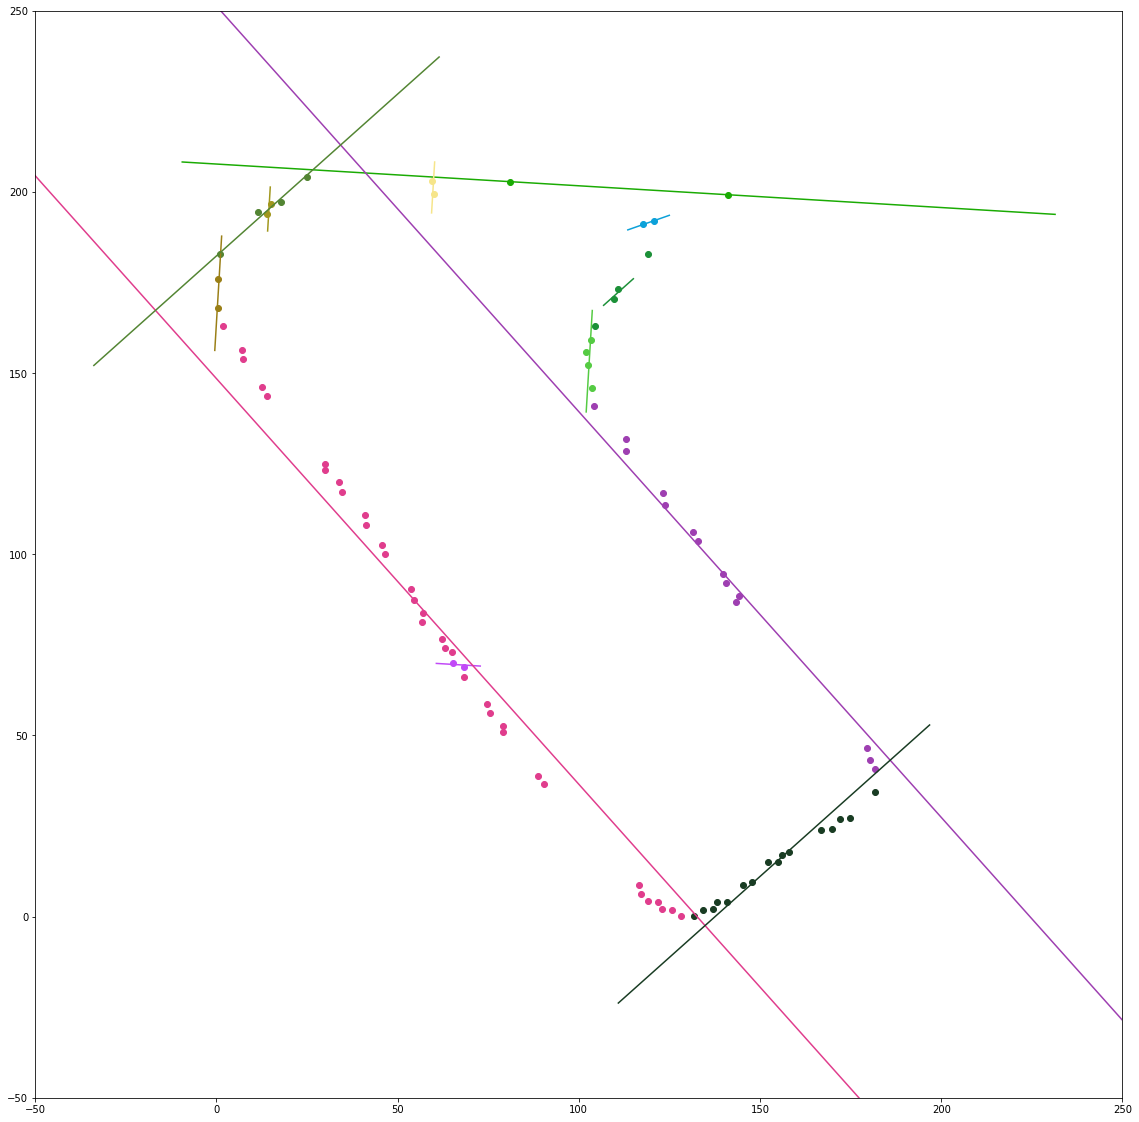

In [56]:
from scipy.optimize import curve_fit
import cv2
from core.utils import get_angle
from shapely.affinity import rotate
from shapely import geometry

def make_fit_func(angle: float):
    def fit_line(x, m, b):
        a = angle
        return m * x + b
    return fit_line

fig, ax = plt.subplots(figsize=(20,20))
ax.set(aspect='equal')
for angle in new_groups:
    group = new_groups[angle]
    for ori in group:
        line_group = group[ori]
        for subgroup in line_group:
            seg = []
#             if len(subgroup) == 1:
#                 continue
            for l in subgroup:
                seg.extend([l[0], l[1]])
            line_angle = (angle if ori == "parallels" else angle - 90) % 180
            [vx, vy, x, y] = np.round(cv2.fitLine(points=np.asarray(seg), distType=cv2.DIST_L2, param=0, reps=0.01, aeps=0.01),2)
            dist = geometry.Point(seg[0]).distance(geometry.Point(seg[-1]))*2
            x1 = float(x - dist * vx)
            x2 = float(x + dist * vx)
            y1 = float(y - dist * vy)
            y2 = float(y + dist * vy)
            fitted_line = [(x1, y1), (x2, y2)]
            angle_delta = line_angle-get_angle(fitted_line)
            ls = rotate(geometry.LineString(fitted_line), angle_delta)

            color = np.random.rand(3,)
            xs = ls.coords.xy[0]
            ys = ls.coords.xy[1]
            x = np.asarray(list(map(lambda p: p[0], seg)))
            y = np.asarray(list(map(lambda p: p[1], seg)))
            fitted_line_new = [(xs[0], ys[0]), (xs[1], ys[1])]
            lc = mc.LineCollection([fitted_line_new], colors=color)
            plt.scatter(x, y, color=color)
            ax.add_collection(lc)
            ax.set_xlim(-50, 250)
            ax.set_ylim(-50, 250)

                